Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.png)

# Automated Machine Learning
_**Forecasting using the Energy Demand Dataset**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data and Forecasting Configurations](#Data)
1. [Train](#Train)
1. [Results](#Results)

Advanced Forecasting
1. [Advanced Training](#advanced_training)
1. [Advanced Results](#advanced_results)

## Introduction

In this example we use the associated New York City energy demand dataset to showcase how you can use AutoML for a simple forecasting problem and explore the results. The goal is predict the energy demand for the next 48 hours based on historic time-series data.

If you are using an Azure Machine Learning [Notebook VM](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-1st-experiment-sdk-setup), you are all set. Otherwise, go through the [configuration notebook](../../../configuration.ipynb) first, if you haven't already, to establish your connection to the AzureML Workspace.

In this notebook you will learn how to:
1. Creating an Experiment using an existing Workspace
1. Configure AutoML using 'AutoMLConfig'
1. Train the model using AmlCompute
1. Explore the engineered features and results
1. Configuration and remote run of AutoML for a time-series model with lag and rolling window features
1. Run and explore the forecast

## Setup

In [2]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-forecasting-energydemand'

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.83
Subscription ID,08d28dbf-1252-4438-b3be-0188e3803935
Workspace,amlwksp2020
Resource Group,amlgrp2020
Location,westus
Run History Name,automl-forecasting-energydemand


## Create or Attach existing AmlCompute
A compute target is required to execute a remote Automated ML run. 

[Azure Machine Learning Compute](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) is a managed-compute infrastructure that allows the user to easily create a single or multi-node compute. In this tutorial, you create AmlCompute as your training compute resource.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "aml-compute"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]

if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_DS12_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.\n",
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)

print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

# For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


# Data

We will use energy consumption [data from New York City](http://mis.nyiso.com/public/P-58Blist.htm) for model training. The data is stored in a tabular format and includes energy demand and basic weather data at an hourly frequency. 

With Azure Machine Learning datasets you can keep a single copy of data in your storage, easily access data during model training, share data and collaborate with other users. Below, we will upload the datatset and create a [tabular dataset](https://docs.microsoft.com/bs-latn-ba/azure/machine-learning/service/how-to-create-register-datasets#dataset-types) to be used training and prediction.

Let's set up what we know about the dataset.

<b>Target column</b> is what we want to forecast.<br></br>
<b>Time column</b> is the time axis along which to predict.

The other columns, "temp" and "precip", are implicitly designated as features.

In [5]:
target_column_name = 'demand'
time_column_name = 'timeStamp'

In [6]:
dataset = Dataset.Tabular.from_delimited_files(path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/nyc_energy.csv").with_timestamp_columns(fine_grain_timestamp=time_column_name) 
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


The NYC Energy dataset is missing energy demand values for all datetimes later than August 10th, 2017 5AM. Below, we trim the rows containing these missing values from the end of the dataset.

In [7]:
# Cut off the end of the dataset due to large number of nan values
dataset = dataset.time_before(datetime(2017, 10, 10, 5))

## Split the data into train and test sets

The first split we make is into train and test sets. Note that we are splitting on time. Data before and including August 8th, 2017 5AM will be used for training, and data after will be used for testing.

In [10]:
# split into train based on time ###  
train = dataset.time_before(datetime(2017, 8, 8, 5), include_boundary=True)
train.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name).tail(5)
#train.shape

,timeStamp,demand,precip,temp
49071,2017-08-08 01:00:00,5106.35,0.00,68.30
49072,2017-08-08 02:00:00,4947.73,0.00,68.44
49073,2017-08-08 03:00:00,4867.02,0.00,68.78
49074,2017-08-08 04:00:00,4888.20,0.00,68.70
49075,2017-08-08 05:00:00,5120.31,0.00,67.53


In [9]:
# split into test based on time
test = dataset.time_between(datetime(2017, 8, 8, 6), datetime(2017, 8, 10, 5))
test.to_pandas_dataframe().reset_index(drop=True).head(5)
print(test)

TabularDataset
{
  "source": [
    "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/nyc_energy.csv"
  ],
  "definition": [
    "GetFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes",
    "ExpressionFilter",
    "ExpressionFilter"
  ]
}


### Setting the maximum forecast horizon

The forecast horizon is the number of periods into the future that the model should predict. It is generally recommend that users set forecast horizons to less than 100 time periods (i.e. less than 100 hours in the NYC energy example). Furthermore, **AutoML's memory use and computation time increase in proportion to the length of the horizon**, so consider carefully how this value is set. If a long horizon forecast really is necessary, consider aggregating the series to a coarser time scale. 

Learn more about forecast horizons in our [Auto-train a time-series forecast model](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-auto-train-forecast#configure-and-run-experiment) guide.

In this example, we set the horizon to 48 hours.

In [10]:
max_horizon = 5

## Train

Instantiate an AutoMLConfig object. This config defines the settings and data used to run the experiment. We can provide extra configurations within 'automl_settings', for this forecasting task we add the name of the time column and the maximum forecast horizon.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**blacklist_models**|Models in blacklist won't be used by AutoML. All supported models can be found at [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.constants.supportedmodels.forecasting?view=azure-ml-py).|
|**experiment_timeout_hours**|Maximum amount of time in hours that the experiment take before it terminates.|
|**training_data**|The training data to be used within the experiment.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross validation splits. Rolling Origin Validation is used to split time-series in a temporally consistent way.|
|**enable_early_stopping**|Flag to enble early termination if the score is not improving in the short term.|
|**time_column_name**|The name of your time column.|
|**max_horizon**|The number of periods out you would like to predict past your training data. Periods are inferred from your data.|


This notebook uses the blacklist_models parameter to exclude some models that take a longer time to train on this dataset. You can choose to remove models from the blacklist_models list but you may need to increase the experiment_timeout_hours parameter value to get results.

In [16]:
automl_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
}

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blacklist_models = ['ExtremeRandomTrees', 'AutoArima', 'Prophet'],                             
                             experiment_timeout_minutes=15,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                            **automl_settings)

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while.
One may specify `show_output = True` to print currently running iterations to the console.

In [17]:
remote_run = experiment.submit(automl_config, show_output= False)

In [18]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-energydemand,AutoML_fdf65fe3-f4c7-45a8-a1e8-be666017b3ae,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [19]:
remote_run.wait_for_completion()

{'runId': 'AutoML_fdf65fe3-f4c7-45a8-a1e8-be666017b3ae',
 'target': 'aml-compute',
 'status': 'Completed',
 'startTimeUtc': '2020-01-26T11:31:39.781757Z',
 'endTimeUtc': '2020-01-26T11:52:24.317768Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'MaxTimeSeconds': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'aml-compute',
  'RawAMLSettingsString': "{'name': 'automl-forecasting-energydemand', 'path': None, 'subscription_id': '08d28dbf-1252-4438-b3be-0188e3803935', 'resource_group': 'amlgrp2020', 'workspace_name': 'amlwksp2020', 'region': 'westus', 'compute_target': 'aml-compute', 'spark_service': None, 'azure_service': None, 'iterations': 1000, 'primary_metric': 'normalized_root_mean_squared_error', 'task_type': 'regression', 'data_script': None, 'validation_size': 0.0, 'n_cross_validations': 3, 'y_min': None, '

## Retrieve the Best Model
Below we select the best model from all the training iterations using get_output method.

In [20]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('stackensembleregressor',
  StackEnsembleRegressor(base_learners=[('5', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7f064ad58240>), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_...timators=25, n_jobs=1,
             oob_score=False, random_state=None, verbose=0, warm_start=False))]))],
              meta_learner=ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
         fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
         n_jobs=None, normalize=False, positive=False, precompute='auto',
         random_state=None, selection='cyclic', tol=0.0001, verbose=0),
              training_cv_folds=5))]

## Featurization
You can access the engineered feature names generated in time-series featurization.

In [21]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

+ Raw feature name
+ Number of engineered features formed out of this raw feature
+ Type detected
+ If feature was dropped
+ List of feature transformations for the raw feature

In [22]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,2,precip,"[MeanImputer, ImputationMarker]",Numeric
1,No,2,temp,"[MeanImputer, ImputationMarker]",Numeric
2,No,11,timeStamp,"[DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer]",DateTime


## Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:

In [23]:
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

### Forecast Function
For forecasting, we will use the forecast function instead of the predict function. Using the predict method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use. Forecast function also can handle more complicated scenarios, see notebook on [high frequency forecasting](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-high-frequency/automl-forecasting-function.ipynb).

In [24]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

### Evaluate
To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [25]:
from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

[Test data scores]

explained_variance:   0.870
r2_score:   -0.130
spearman_correlation:   0.970
mean_absolute_percentage_error:   13.521
mean_absolute_error:   933.432
normalized_mean_absolute_error:   0.296
median_absolute_error:   1040.559
normalized_median_absolute_error:   0.330
root_mean_squared_error:   992.099
normalized_root_mean_squared_error:   0.315
root_mean_squared_log_error:   0.153
normalized_root_mean_squared_log_error:   0.313


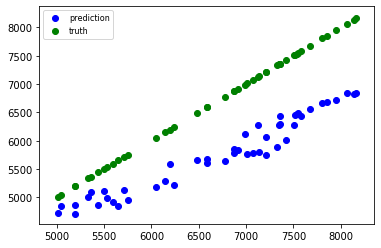

In [26]:
from azureml.automl.core._vendor.automl.client.core.common import metrics
from matplotlib import pyplot as plt
from automl.client.core.common import constants

# use automl metrics module
scores = metrics.compute_metrics_regression(
    df_all['predicted'],
    df_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

Looking at `X_trans` is also useful to see what featurization happened to the data.

In [28]:
X_trans

,,precip,temp,precip_WASNULL,temp_WASNULL,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timeStamp,_automl_dummy_grain_col,,,,,,,,,,,,,,,,
2017-08-08 06:00:00,_automl_dummy_grain_col,0.00,66.17,0,0,2017,2,3,8,8,6,0,6,1,39,32,4924.31
2017-08-08 07:00:00,_automl_dummy_grain_col,0.00,66.29,0,0,2017,2,3,8,8,7,0,7,1,39,32,5281.73
2017-08-08 08:00:00,_automl_dummy_grain_col,0.00,66.72,0,0,2017,2,3,8,8,8,0,8,1,39,32,5683.89
2017-08-08 09:00:00,_automl_dummy_grain_col,0.00,67.37,0,0,2017,2,3,8,8,9,0,9,1,39,32,5783.91
2017-08-08 10:00:00,_automl_dummy_grain_col,0.00,68.30,0,0,2017,2,3,8,8,10,0,10,1,39,32,5770.96
2017-08-08 11:00:00,_automl_dummy_grain_col,0.00,68.89,0,0,2017,2,3,8,8,11,0,11,1,39,32,5776.68
2017-08-08 12:00:00,_automl_dummy_grain_col,0.00,70.60,0,0,2017,2,3,8,8,12,1,12,1,39,32,5740.90
2017-08-08 13:00:00,_automl_dummy_grain_col,0.00,72.83,0,0,2017,2,3,8,8,13,1,1,1,39,32,5880.99
2017-08-08 14:00:00,_automl_dummy_grain_col,0.00,73.33,0,0,2017,2,3,8,8,14,1,2,1,39,32,6014.88


## Advanced Training <a id="advanced_training"></a>
We did not use lags in the previous model specification. In effect, the prediction was the result of a simple regression on date, grain and any additional features. This is often a very good prediction as common time series patterns like seasonality and trends can be captured in this manner. Such simple regression is horizon-less: it doesn't matter how far into the future we are predicting, because we are not using past data. In the previous example, the horizon was only used to split the data for cross-validation.

### Using lags and rolling window features
Now we will configure the target lags, that is the previous values of the target variables, meaning the prediction is no longer horizon-less. We therefore must still specify the `max_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

This notebook uses the blacklist_models parameter to exclude some models that take a longer time to train on this dataset.  You can choose to remove models from the blacklist_models list but you may need to increase the iteration_timeout_minutes parameter value to get results.

In [ ]:
automl_advanced_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    'target_lags': 12,
    'target_rolling_window_size': 4,
}

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blacklist_models = ['ElasticNet','ExtremeRandomTrees','GradientBoosting','XGBoostRegressor','ExtremeRandomTrees', 'AutoArima', 'Prophet'], #These models are blacklisted for tutorial purposes, remove this for real use cases.                            
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping = True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                            **automl_advanced_settings)

We now start a new remote run, this time with lag and rolling window featurization. AutoML applies featurizations in the setup stage, prior to iterating over ML models. The full training set is featurized first, followed by featurization of each of the CV splits. Lag and rolling window features introduce additional complexity, so the run will take longer than in the previous example that lacked these featurizations.

In [ ]:
advanced_remote_run = experiment.submit(automl_config, show_output=False)

In [ ]:
advanced_remote_run.wait_for_completion()

### Retrieve the Best Model

In [ ]:
best_run_lags, fitted_model_lags = advanced_remote_run.get_output()

## Advanced Results<a id="advanced_results"></a>
We did not use lags in the previous model specification. In effect, the prediction was the result of a simple regression on date, grain and any additional features. This is often a very good prediction as common time series patterns like seasonality and trends can be captured in this manner. Such simple regression is horizon-less: it doesn't matter how far into the future we are predicting, because we are not using past data. In the previous example, the horizon was only used to split the data for cross-validation.

In [ ]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model_lags.forecast(X_test)

In [ ]:
from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

In [ ]:
from azureml.automl.core._vendor.automl.client.core.common import metrics
from matplotlib import pyplot as plt
from automl.client.core.common import constants

# use automl metrics module
scores = metrics.compute_metrics_regression(
    df_all['predicted'],
    df_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()